# Purpose

This notebook is a working exploration of classification algorithms.

# MNIST Dataset

MNIST dataset is a set of 70,000 small images of digits handwritten by highschool students.  It is a commonly studied dataset for classification problems.  I'll access it via `sklearn`.   

In [1]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version=1)
mnist.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

Separating out the features and target variable.

In [2]:
X, y = mnist["data"], mnist["target"]
#forcing to numpy array
X = X.to_numpy()
y = y.to_numpy()

print("X shape: {}, y shape: {}".format(X.shape, y.shape))

X shape: (70000, 784), y shape: (70000,)


There are 70,000 images (rows) and each have 784 features (columns) because each image is 28 x 28 pixels and each feature simply represents each pixel's intensity froom 0 (white) to 255 (black).  I can look at an individual image using `matplotlib`'s `imshow()` function.

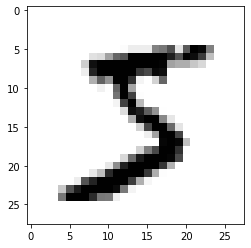

In [3]:
import matplotlib as mpl
import matplotlib.pyplot as plt

some_digit = X[0]
some_digit_image = some_digit.reshape(28, 28)

plt.imshow(some_digit_image, cmap="binary")
plt.show()

This digit looks like a 5 to me and below I'm confirming that is in fact how it is labeled.  Notice the label is a string, so I'm also going to cast y to integer.

In [4]:
import numpy as np
print('image label: {}, label type: {}'.format(y[0], type(y[0])))

y = y.astype(np.uint8)

image label: 5, label type: <class 'str'>


Of course, before I do any EDA work I want to split out a test dataset.  In the case of the MNIST dataset, this is already separated for me.  The first 60,000 images are my training set and the final 10,000 are my test set.  The training set is already shuffled, which is good in this case but would not be in some other cases, e.g. time series, because it ensures all CV folds will contain similar digits.

In [5]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

# Training a Binary Classifier

First, I'm going to simplify the problem by training a binary classifier to look for the digit 5.  I'll begin with a _Stochastic Gradient Descent_ (SGD) classifier using `SGDClassifier` from Scikit-Learn and simply train it on the entirety of our binary 5 dataset.

In [6]:
y_train_5 = (y_train == 5)
y_test_5 = (y_test == 5)

from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state=33)
sgd_clf.fit(X_train, y_train_5)

print("Does my model predict a 5 for the some_digit example above? {}".format(sgd_clf.predict([some_digit])))

Does my model predict a 5 for the some_digit example above? [ True]


# Performance Measures

Measuring performance of a classifier can be quite a bit trickier than measuring perfoormance of a regressor so I'm going to go through several topics here.

## Measuring Accuracy Using Cross-Validation

A reasonable first step is to measure accuracy using cross-fold validation similar to the process from the previous chapter.

In [7]:
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring='accuracy')

array([0.913  , 0.9674 , 0.95865])

Those accuracy measures may look high but it's important to remember how limited accuracy can be when we're dealing with classifiers.  In order to prove this point I'm going to make a dumb classifier below which simply predicts False everywhere, e.g. all digits are "not 5", and compare the accuracy measures to the above model.

In [8]:
from sklearn.base import BaseEstimator

class Never5Classifier(BaseEstimator):
    def fit(self, X, y=None):
        return self
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)

never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring='accuracy')

array([0.91125, 0.90855, 0.90915])

The accuracy of the dumb model above is above 90% and that's because roughly 10% of the digits in the training set are 5.  This illustrates why more care is needed in evaluating the performance of classifiers, especially when dealing with _skewed datasets_, i.e. when some classes are much more frequent than others.

## Confusion Matrix

A better way to evaluate a classifier is to use the confusion matrix, which is a matrix that contains comparisons of all 4 possible outcomes (for a binary classifier).  In order to generate the confusion matrix, I'll first predict along my entire training set using `cross_val_predict` and then use Sci-kit Learn's `confusion_matrix()`.  

Each row in a confusion matrix represents an _actual class_ and each column represents a _predicted class_.  In our example below, the first row represents non-5 images (the _negative class_).  Column 1 tells us that 52,663 were correctly identified as non-5 digits (_true negative_) and column 2 tells us that 1,916 were incorrectly identified as 5s (_false positive_).  The second row represents images of 5s (the _positive class_).  Column 1 tells us that 1,303 were incorrectly identified as non-5 images (_false negative_) and 4,118 were correctly identified as 5s (_true positive_).  A perfect classifier would only contain true positives and true negatives so it would only contain nonzeros in its main diagonal, top left to bottom right.

In [10]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)
print("Confusion Matrix:\n{}".format(confusion_matrix(y_train_5, y_train_pred)))

Confusion Matrix:
[[52663  1916]
 [ 1303  4118]]


## Precision, Recall, and F1 Score

The confusion matrix displays a lot of information about the classifier's performance, especially for multi-class classifiers, but when you want a more concise measure of performance, precision and recall are typically used.  Precision is a measure of how many of the positive predictions are correct ($\frac {TP}{TP + FP}$) and recall, or sensitivity, is the ratio of positive instances that are correctly detected by the classifier ($\frac {TP}{TP + FN}$).  A convenient way to combine precision and recall is the $F_1$ score, which takes the harmonic mean of precision and recall.  The harmonic mean gives much more weight to low values than the standard mean weights all values the same, therefore a classifier will only have a high $F_1$ score if both precision and recall are high.

In [16]:
from sklearn.metrics import precision_score, recall_score, f1_score

msg = f'''
Precision: {precision_score(y_train_5, y_train_pred)}
Recall: {recall_score(y_train_5, y_train_pred)}
F1 Score: {f1_score(y_train_5, y_train_pred)}
'''
print(msg)


Precision: 0.6824660258534968
Recall: 0.7596384430916805
F1 Score: 0.7189873417721518



$F_1$ score favors classifiers that have similar precision and recall though this might not always be what you want.  For example if you were training a classifier to detect which videos are suitable for children, you'd likely prefer a classifier that rejects some good videos (low recall) but keeps only safe ones (high precision).  Similarly if you were training a classifier to catch shoplifters you'd likely care about the opposite.

## Precision/Recall Tradeoff

Precision and recall are necessarily inversely related, by raising one you must lower the other.  To alter this relationship you must adjust the thershold by which the classifier determines the class.  Sci-kit Learn does not let you adjust this threshold directly, though it does let you output the decision threshold using the `decision_function()` method.  Then you can simply define your own threshold for class determination.

In [19]:
y_some_digit_decision = sgd_clf.decision_function([some_digit])

msg = f'''
Class at threshold = 0: {y_some_digit_decision > 0}
Class at threshold = 1000: {y_some_digit_decision > 1000}
'''

print(msg)


Class at threshold = 0: [ True]
Class at threshold = 1000: [False]



Above, I'm raising the threshold from zero (the default) to 1,000 and I can see that this changes my prediction from "5" to "not 5", lowering recall.  In order to see how threshold selection affects precision and recall over all possible options, I'm going to use `cross_val_predict()` and `decition_function()` to predict across the entire training set, then `precision_recall_curve()` to generate and plot all possible selections.

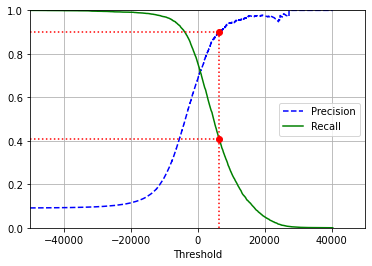

In [28]:
from sklearn.metrics import precision_recall_curve

y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3, method='decision_function')
precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
    plt.xlabel("Threshold")
    plt.legend(loc="right")
    plt.grid(True)
    plt.axis([-50000, 50000, 0, 1])

#determine recall and threshold at 90% precision for plot highlighting
#np.argmax gives me the first index of the max value, in this case the first True value
#because recalls is ordered from largest to smallest, this gives me the largest recall at 90% precision
recall_90_precision = recalls[np.argmax(precisions >= 0.90)]
#because thresholds is ordered from smallest to largest, this gives me the smallest threshold at 90% precision
threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)]

plot_precision_recall_vs_threshold(precisions, recalls, thresholds)

#add highlighted 90% precision selection
plt.plot([threshold_90_precision, threshold_90_precision], [0., 0.9], "r:")                 
plt.plot([-50000, threshold_90_precision], [0.9, 0.9], "r:")                                
plt.plot([-50000, threshold_90_precision], [recall_90_precision, recall_90_precision], "r:")
plt.plot([threshold_90_precision], [0.9], "ro")                                             
plt.plot([threshold_90_precision], [recall_90_precision], "ro")                             

plt.show()

Another way to select the best tradeoff is to plot precision as a function of recall directly.

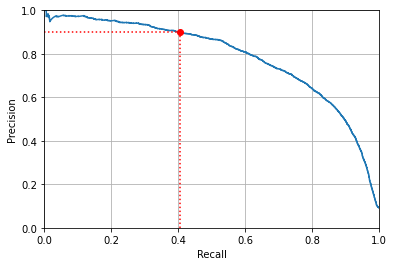

In [31]:
plt.plot(recalls, precisions)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.axis([0,1,0,1])
plt.grid(True)

#highlight the same 90% precision point
plt.plot([recall_90_precision, recall_90_precision], [0., 0.9], "r:")
plt.plot([0.0, recall_90_precision], [0.9, 0.9], "r:")
plt.plot([recall_90_precision], [0.9], "ro")

plt.show()

## ROC Curve

Another common performance measure for binary classifiers is the _receiver operating characteristic_ (ROC) curve.  The ROC curve plots the _true positive rate_ (TPR or recall) against the _false positive rate_ (FPR).  We can get FPR and TPR at all relevant thresholds using Sci-kit Learn's `roc_curve()` and then plot them using matplotlib in order to take a look at the ROC curve.

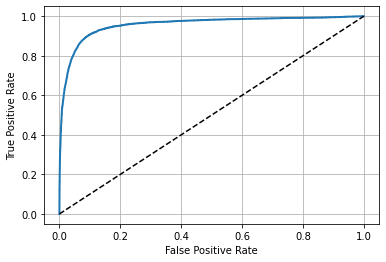

In [35]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0,1], [0,1], 'k--') #dashed diagonal 1:1 line for comparison
    plt.grid(True)
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")

plot_roc_curve(fpr, tpr)
plt.show()

The ROC curve further illustrates the trade off; the higher the recall (TPR), the more false positives (FPR) the classifier produces.  The dashed 1:1 line represents a random classifier.  A good classifier should stay as far away as possible from this line, in the upper left corner of the plot.  One way to compare classifiers is to measure the _area under the curve_ (AUC).  A perfect classifier has an AUC equal to 1.  AUC can be calculated using Sci-kit Learn's `roc_auc_score()`.

In [39]:
from sklearn.metrics import roc_auc_score
print("AUC: ", roc_auc_score(y_train_5, y_scores))

AUC:  0.9565951186469316


A good rule of thumb when determining which to use between the precision/recall (PR) curve and the ROC curve is that you should prefer the PR curve whenever the positive class is rare or when you care more about false positives than false negatives.  Otherwise, use the ROC curve.  Taking our example above, the ROC curve makes the classifier look fairly decent because the rate of true 5s in the dataset is quite low.

Now I'll train a `RandomForestClassifier` and compare it to the `SDGClassifier` above.  In order to generate the scores for the `RandomForestClassifier` I'll have to use its `predict_proba()` method.  

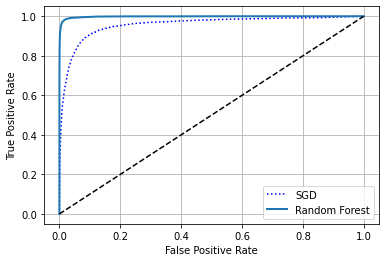


SGD AUC = 0.9565951186469316
RF AUC = 0.9982396047484723



In [48]:
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(random_state=33)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3, method="predict_proba")

#predict_proba gives a column for the probability of each class
#choosing the second column as the score = prob of positive class
y_scores_forest = y_probas_forest[:, 1]
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5, y_scores_forest)

#comparing ROC curves
plt.plot(fpr, tpr, "b:", label="SGD")
plot_roc_curve(fpr_forest, tpr_forest, "Random Forest")
plt.legend(loc="lower right")
plt.show()

#comparing AUC
msg = f'''
SGD AUC = {roc_auc_score(y_train_5, y_scores)}
RF AUC = {roc_auc_score(y_train_5, y_scores_forest)}
'''
print(msg)


It's pretty clear from both the ROC curve and the AUC that the `RandomForestClassifier` is superior to the `SGDClassifier` at predicting 5s.  Now lets try to predict more than 5s!